# <center>Сборный проект 1
# <center>Исследование продаж видеоигр

## Описание проекта

Из открытых источников нам доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Нужно отработать принцип работы с данными для формирования рекламной стратегии на 2017 год.

## Формулировка задания и план выполнения

1. Изучить полученный датасет, просмотреть общую информацию.
2. Произвести предобработку данных:
 - Преобразовать данные в нужный тип;
 - Обработать пропуски и дубликаты (при необходимости);
 - Посчитать суммарные продажи игр во всех регионах.
3. Произвести исследовательский анализ данных:
 - Определить актуальный период, за который будет производиться анализ;
 - Выделить актуальные и потенциально прибыльные платформы;
 - Проанализировать зависимость продаж от платформы, отзывов критиков и пользователей, жанра, построить графики.
4. Для пользователей каждого региона (NA, EU, JP) определить:
 - 5 наиболее популярных платформ;
 - 5 наиболее полулярных жанров;
 - Степень влияния рейтинга ESRB на продажи.
5. Проверить гипотезы:
 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
 - Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

## Описание данных
Файл ___games.csv___, в котором для каждой игры указана следующая информация:

- __Name__ — название игры
- __Platform__ — платформа
- __Year_of_Release__ — год выпуска
- __Genre__ — жанр игры
- __NA_sales__ — продажи в Северной Америке (миллионы долларов)
- __EU_sales__ — продажи в Европе (миллионы долларов)
- __JP_sales__ — продажи в Японии (миллионы долларов)
- __Other_sales__ — продажи в других странах (миллионы долларов)
- __Critic_Score__ — оценка критиков (максимум 100)
- __User_Score__ — оценка пользователей (максимум 10)
- __Rating__ — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
# Импорт модулей
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display, display_html 

In [2]:
plt.style.use('seaborn')

## Шаг 1: Изучение полученных данных

Посмотрим общую информацию о полученной таблице и выведем для наглядности несколько строк:

In [3]:
games = pd.read_csv('/datasets/games.csv')
display(games.sample(10))
games.info()

Name Platform  Year_of_Release         Genre  \
15659                    Earth Seeker      Wii           2011.0  Role-Playing   
7515           Buzz! The Schools Quiz      PS2           2008.0          Misc   
12328                   Darksiders II     XOne           2015.0        Action   
11581                  Lost Dimension      PSV           2014.0  Role-Playing   
3409      Disney Sing It: Family Hits      Wii           2010.0          Misc   
12595              Puzzler Collection      Wii           2008.0        Puzzle   
352                    FIFA Soccer 10      PS3           2009.0        Sports   
6737          Nickelodeon Party Blast       GC           2002.0          Misc   
5550                Nicktoons: Movin'      PS2           2004.0        Action   
6092   Dragon Ball GT: Transformation      GBA           2005.0        Action   

       NA_sales  EU_sales  JP_sales  Other_sales  Critic_Score User_Score  \
15659      0.00      0.00      0.02         0.00           NaN        NaN   
7515       0.00      0.02      0.00         0.19           NaN        NaN   
12328      0.04      0.02      0.00         0.01           NaN        NaN   
11581      0.03      0.01      0.02         0.02          72.0        8.3   
3409       0.38      0.17      0.00         0.05           NaN        tbd   
12595      0.05      0.00      0.00         0.00           NaN        tbd   
352        0.60      2.45      0.05         0.52          91.0        7.6   
6737       0.19      0.05      0.00         0.01           NaN        tbd   
5550       0.16      0.12      0.00         0.04           NaN        tbd   
6092       0.20      0.08      0.00         0.01          69.0        8.2   

      Rating  
15659    NaN  
7515     NaN  
12328    NaN  
11581      T  
3409       E  
12595      E  
352        E  
6737       E  
5550       E  
6092    E10+

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таблица состоит из 16715 записей и 11 столбцов. Используемые типы данных: строковый (*object*)  и вещественный (*float64*). В ряде столбцов присутствуют пропуски.

Приведем названия столбцов к нижнему регистру:

In [4]:
games.columns = games.columns.str.lower()
# games.columns      #Проверка

## Шаг 2: Предобработка данных
### 1. Обработка пропусков
Рассмотрим подробнее столбцы таблицы на предмет пропущенных и недопустимых значений.
#### Name, Genre
В столбцах __name__ и __genre__ заполнено  по 16713 значений из 16715. Выведем строки, где не указано название игры:

In [5]:
games[games['name'].isna()]

name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN

Мы видим две записи об играх на приставке Sega Genesis, которые были выпущены в 1993 году. Пропуски в полях с названием игры и ее жанром могут быть вызваны единичным сбоем при выгрузке или сохранении данных.

В любом случае, информация об этих играх вряд ли будет актуальна для 2017 года, так что можно смело удалить их из таблицы.

In [6]:
games.dropna(subset=['name'], inplace = True)

#### Year of Release
В столбце **year_of_release** присутствует 269 пропущенных значений. Скорее всего, при вводе информации о данных играх просто не был указан год выпуска. 

Попробуем заполнить некоторые из пропусков. Для этого обратим внимание на то, что в таблице могут быть записи об одной игре, выпущенной на разных платформах, причем для некоторых платформ год выпуска указан, а для других - нет. Соответственно, столбец **year_of_release** для таких игр можно заполнить на основании сведений о релизе на других платформах.

Мы воспользуемся функцией ***fill_na_by_category***, которая будет заполнять пропуски в заданном столбце рассчетным значением (средним, медианой и т.д.) по определенной группе записей (в данном случае группировать следует по названию игры). 

Стоит также заметить, что год выхода игры на разных платформах может различаться, но с учетом небольшой доли пропусков это не должно повлиять на общую картину:

In [7]:
def fill_na_by_category(column_to_fill, category, aggfunc = 'mean'):

    ''' Функция для заполнения пропусков рассчетным значением по категории'''

    filled_vals_dict = (games.groupby(category)[column_to_fill]
                        .transform(aggfunc)) #группируем по категории и находим расчетное значение для группы
    games[column_to_fill].fillna(filled_vals_dict, inplace = True) # заполняем пропуски рассчетным значением
    print(f'В столбце {column_to_fill} осталось {games[column_to_fill].isna().sum()} пропусков') # проверка

fill_na_by_category('year_of_release', 'name', 'max')

В столбце year_of_release осталось 146 пропусков


Оставшиеся пропуски можно заполнить медианным значением года выпуска для игр на каждой платформе:

In [8]:
fill_na_by_category('year_of_release', 'platform', lambda x: round(x.median()))

В столбце year_of_release осталось 0 пропусков


#### Rating

Теперь изучим столбец **rating**, в котором указан возрастной рейтинг игры. 

In [9]:
print('Пропусков в столбце:', games['rating'].isna().sum())

Пропусков в столбце: 6764


Количество пропусков весьма значительно. Это может быть связано с тем, что для некоторых игр возрастной рейтинг либо не был указан, либо отсутствовал при добавлении в базу. Для того, чтобы принять решение, заполнять пропуски или нет, сперва посмотрим, какие значения встречаются в таблице:

In [10]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Тут можно высказать следующие соображения:
- игр с рейтингом ***K-A*** (kids to adults, для детей и взрослых, устаревшее обозначение рейтинга ***E***) и ***EC*** (early childhood, для детей младшего возраста) всего 11. Рассматривать их отдельно не имеет смысла, так что отнесем эти записи к категории ***E*** (everyone, для всех);
- ***AO*** (adults only, только для взрослых) по тем же соображениям можно отнести к категории ***M*** (mature, для взрослых);
- ***RP*** (rating pending, в ожидании рейтинга) проставляется, когда игра еще не получила рейтинг ESRB, и по сути является пропуском.

В соответствии с вышесказанным объединим категории ***E, EC*** и ***K-A***, а также ***M*** и ***AO***. Рейтинг ***RP*** будем считать пропуском.

In [11]:
games.loc[games['rating'].isin(['EC', 'K-A']), 'rating'] = 'E'
games.loc[games['rating'] == 'AO', 'rating'] = 'M'
games['rating'] = games['rating'].mask(games['rating'] == 'RP')
games['rating'].value_counts()         #Проверка

E       4001
T       2961
M       1564
E10+    1420
Name: rating, dtype: int64

Посмотрим, как возрастные рейтинги распределены по жанрам:

In [12]:
genre_ratings = games.fillna('Неизвестен').groupby(['genre', 'rating'])['name'].count().reset_index()
fig = px.bar(genre_ratings, x='genre', y='name', color = 'rating', barmode = 'group', 
             title = 'Распределение возрастного рейтинга по жанрам', 
             labels = {'genre': 'Жанры', 'name': 'Количество игр', 'rating': 'Рейтинг'}, height = 400)
fig.show()

Можно видеть, что для некоторых жанров (например, спортивных игр) поле **rating** имеет ярко выраженную моду, которой можно заполнить пустые значения. Для других жанров таких сильных максимумов нет, но в целом можно сказать, что распределение возрастных рейтингов соответствует ожиданиям - подавляющее большинство спортивных и гоночных игр имеет рейтинг "для всех", экшн-игры и шутеры предназначены в первую очередь для подростков и взрослых и т.д.

В то же время мы видим, что количество пропущенных значений почти во всех жанрах намного превышает моды данного столбца. Исходя из этого, считаем, что заполнять их было бы неправильно, поскольку это очень сильно повлияет на распределение величины и результаты анализа. Оставим пропуски незаполненными.

#### User Score, Critic score

В данных столбцах также содержится большое количество пропусков:

In [13]:
print('Пропусков в столбце user_score:', games['user_score'].isna().sum())
print('Пропусков в столбце critic_score:', games['critic_score'].isna().sum())

Пропусков в столбце user_score: 6699
Пропусков в столбце critic_score: 8576


В столбце **user_score**  также встречаются значения ___tbd___ , означающие, что пользовательский рейтинг еще не рассчитан. Появление такой записи связано с тем, что на многих сайтах-аггрегаторах обзоров игр общий пользовательский рейтинг рассчитывается только после того, как количество обзоров на игру достигает определенного количества; соответственно, ___tbd___ (to be determined) показывает, что количество пользовательских оценок еще недостаточно для рассчета рейтинга. 

In [14]:
print('Значений "tbd"  в user_score:', (games['user_score'] == 'tbd').sum())

Значений "tbd"  в user_score: 2424


Значение ***tbd*** является пропуском в данных. Удалим данные значения из таблицы, а заодно приведем пользовательские отзывы к шкале от 0 до 100 (чтобы избавиться от дробных значений):

In [15]:
games['user_score'] = pd.to_numeric(games['user_score'], errors = 'coerce') * 10

Поскольку далее нами будут проверяться некоторые гипотезы, касающиеся распределения значений пользовательского рейтинга, заполнять пропуски в данном столбце мы тоже не будем - с учетом их значительного количества (более половины записей) подстановка рассчетных значений может сильно повлиять на дисперсию величины, а соответственно  и результаты анализа.

### 2. Преобразование типов данных
Преобразуем значения столбца **year_of_release** к целочисленному типу:

In [72]:
games['year_of_release'] = pd.to_numeric(games['year_of_release'], downcast = 'integer')

Остальные столбцы с числовыми значениями (продажи по различным регионам, оценки) привести к целочисленному типу   не получится. Поэтому просто понизим их битность для экономии памяти.

In [73]:
for column in range(4, 10):
    games.iloc[:, column] = pd.to_numeric(games.iloc[:, column], downcast = 'float')
games.info() # проверка

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float32
eu_sales           16713 non-null float32
jp_sales           16713 non-null float32
other_sales        16713 non-null float32
critic_score       8137 non-null float32
user_score         7590 non-null float32
rating             9946 non-null object
dtypes: float32(6), int16(1), object(4)
memory usage: 1.1+ MB


### 3. Рассчет суммарных продаж

Для каждой игры подсчитаем общие продажи по всем регионам:

In [74]:
games['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)
games.head(5) # проверка

name platform  year_of_release         genre  \
0                Wii Sports      Wii             2006        Sports   
1         Super Mario Bros.      NES             1985      Platform   
2            Mario Kart Wii      Wii             2008        Racing   
3         Wii Sports Resort      Wii             2009        Sports   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   

    na_sales   eu_sales  jp_sales  other_sales  critic_score  user_score  \
0  41.360001  28.959999      3.77         8.45          76.0        80.0   
1  29.080000   3.580000      6.81         0.77           NaN         NaN   
2  15.680000  12.760000      3.79         3.29          82.0        83.0   
3  15.610000  10.930000      3.28         2.95          80.0        80.0   
4  11.270000   8.890000     10.22         1.00           NaN         NaN   

  rating  total_sales  
0      E    82.539993  
1    NaN    40.240002  
2      E    35.520000  
3      E    32.770000  
4    NaN    31.380001

### Выводы:

На этом шаге нами произведена предобработка данных:
- Удалены пропуски из столбцов __name__ и __genre__;
- В столбцах __year_of_release__ и __rating__ пропуски заполнены рассчетными значениями;
- В столбцах __critic_score__ и __user_score__ пропуски решено не заполнять.

Помимо этого, мы преобразовали данные к более удобным типам, а также рассчитали для каждой игры показатель суммарных продаж на всех платформах.

## Шаг 2: Анализ данных
### 1. Нахождение актуального временного периода и платформ

Для того, чтобы определить актуальный временной период для нашего исследования, сперва посмотрим, сколько игр выходило в разные годы:

In [75]:
fig1 = px.histogram(games, x = 'year_of_release', y = 'name', nbins = 37, title = 'Количество игр по годам', 
                    labels = {'name': 'Количество игр', 'year_of_release': 'Год'}, height = 400)
fig1.show()

Как видно по графику, пик количества выпущенных игр пришелся на 2005 - 2010 годы. В более поздний период наблюдается некоторый спад по выходу новых игр. Стоит также учесть, что данные за 2016 год - неполные.

Посмотрим, какой вклад в количество выходящих игр вносят различные консоли:

In [76]:
games_by_platform = games.groupby(['platform', 'year_of_release'])['name'].count().reset_index().fillna(0)
fig1 = px.area(games_by_platform, x = 'year_of_release', y = 'name', color = 'platform', height = 500,
              labels = {'name': 'Количество игр', 'year_of_release': 'Год', 'platform': 'Платформа'})
fig1.show()

В таком виде график не слишком информативен, однако можно заметить, что большинство платформ имеет определенный "срок жизни", на протяжении которого для них выходит значительное количество новых игр. Попробуем определить этот срок: сперва выделим несколько наиболее популярных платформ (по общему количеству продаж):

In [77]:
sales_by_platform = games.pivot_table(columns = 'year_of_release', 
                                      index = 'platform',
                                      values = 'total_sales', 
                                      aggfunc = 'sum')
top_platforms = sales_by_platform.sum(axis = 1).sort_values(ascending = False)[0:6].reset_index()
top_platforms.columns = ['platform', 'total_sales']
top_platforms

platform  total_sales
0      PS2  1255.770020
1     X360   971.420044
2      PS3   939.649963
3      Wii   907.510010
4       DS   806.119934
5       PS   730.859985

Теперь посмотрим, как продажи для этих платформ менялись с течением времени:

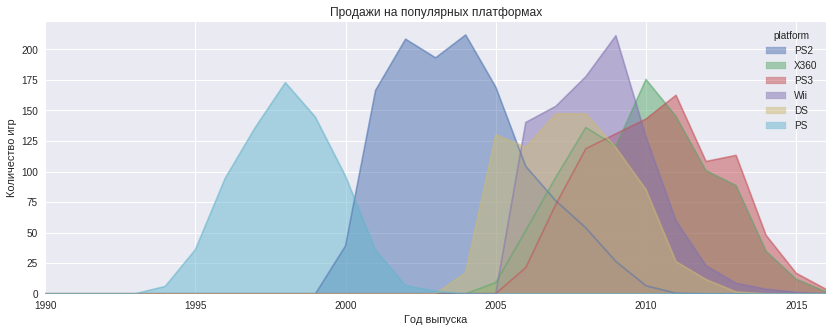

In [78]:
ax = sales_by_platform.loc[top_platforms['platform']].transpose().plot.area(stacked = False, 
                                                                            figsize = (14, 5), 
                                                                            xlim = (1990, 2016),
                                                                            title = 'Продажи на популярных платформах')
ax.set(xlabel = 'Год выпуска', ylabel = 'Количество игр')
plt.show()

Как видно, срок жизни платформы (период, когда на ней выходят новые игры) составляет порядка 7-10 лет. Однако наибольшая активность (рост продаж) продолжается обычно не более 4-6 лет, после чего популярность платформы начинает идти на убыль и ей на замену приходит новое поколение (хорошо видно на графике на примере консолей фирмы Sony - PS, PS2, PS3)

Исходя из данных наблюдений, в дальнейшем целесообразно рассматривать только игры, вышедшие за последние 6 лет.

Что касается платформ, логичным решением будет выделить только те из них, которые актуальны на момент анализа (для которых выходили игры в 2016 году).

In [79]:
relevant_platforms = sales_by_platform.loc[sales_by_platform[2016].notna()].index
relevant_games = games.query('platform in @relevant_platforms and year_of_release > 2010')
print('Размер получившейся выборки:', relevant_games.shape[0])

Размер получившейся выборки: 3561


### 2. Выделение потенциально прибыльных платформ
Изучим тренды продаж для выбранных нами платформ:

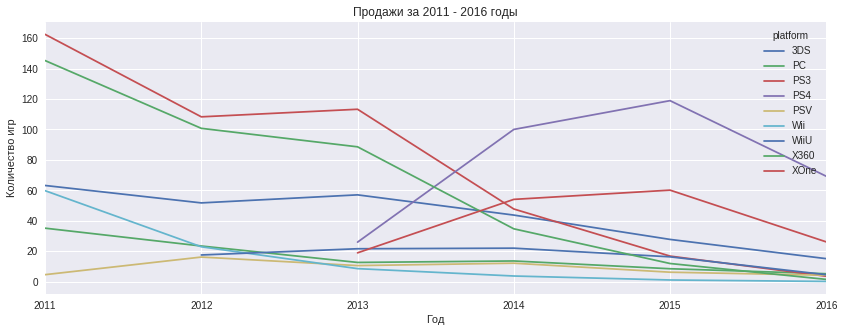

In [80]:
relevant_sales = sales_by_platform.loc[relevant_platforms]
relevant_sales = relevant_sales.iloc[:, 31:37]
ax = relevant_sales.transpose().plot.line(figsize = (14,5), 
                                          title = 'Продажи за 2011 - 2016 годы')
ax.set(xlabel = 'Год', ylabel = 'Количество игр')
plt.show()

Мы видим, что консоли X Box One и PS4 лидируют по продажам и в настоящее время испытывают рост (учитываем, что данные за 2016 год - неполные). Это вполне ожидаемо, поскольку они появились сравнительно недавно и относятся к текущему поколению игровых консолей.

Платформы предыдущего поколения (PS 3, X Box 360, Wii, 3DS) падают по продажам.

Отдельно можно отметить консоль WiiU, которая тоже принадлежит текущему поколению, но не может похвастаться высокими продажами ввиду своей нишевости, а также персональные компьютеры, продажи на которых в силу специфики платформы распределяются равномерно на длительном отрезке времени.

Исходя из этого, потенциально прибыльными платформами можно назвать новое поколение консолей - X Box One и PS4. В качестве более-менее стабильной платформы, на которой гарантирован определенный (невысокий) уровень продаж, также можно отметить PC. Остальные платформы в настоящее время теряют актуальность.

### 3.Анализ зависимости размера продаж от различных факторов

#### Различия по продажам игр на разных платформах

Изучим, как распределены суммарные продажи игр по разным платформам:

In [81]:
fig1 = px.box(relevant_games, x="platform", y="total_sales", height = 400,
             labels = {'platform': 'Платформа', 'total_sales':'Число проданных копий игры'},
             title = 'Продажи игр по платформам')
fig1.show()

Здесь мы видим, что наиболее успешные игры в плане продаж выходили на консолях PS3, PS4, XBox 360 и 3DS. На остальных платформах сборы от хитовых релизов были меньше - худший результат в этом плане показывает Playstation Vita.

Однако эти выбросы обусловлены не платформой, а скорее хитовостью самих игр. Больший интерес представляют  значения, заключенные в рамках "ящиков":

In [82]:
fig1.update_yaxes(range = [0, 1])
fig1.show()

Тут разница уже не такая большая: медианное значение общих продаж по каждой игре для большинства платформ находится в районе 200 тысяч. Значительно меньше уровень продаж у консолей 3DS и PS Vita, а также персональных компьютеров. 

#### Влияние на продажи игры отзывов критиков и пользователей

Рассмотрим на примере наиболее популярных в настоящее время платформ (PS4 и XBox One), каким образом соотносятся продажи игры с отзывами на нее: построим графики рассеяния и найдем коэффициент корреляции между полученной оценкой и продажами игры.

Коэффициент корреляции между оценкой критиков и продажами игры:		 0.3945748363515537
Коэффициент корреляции между пользовательской оценкой и продажами игры:	 -0.03596822447253941


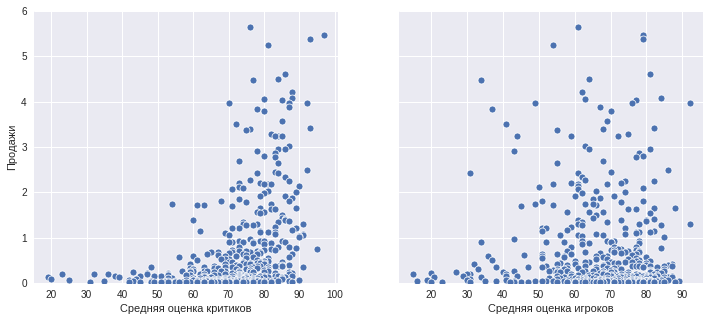

In [83]:
ps4_xone_games = relevant_games.query('platform in ["XOne", "PS4"]')

f, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1 = sns.scatterplot(data = ps4_xone_games, x = 'critic_score', y = 'total_sales', ax = axes[0])
ax1.set(xlabel = 'Средняя оценка критиков', ylabel = 'Продажи', ylim = (0, 6))

ax2 = sns.scatterplot(data = ps4_xone_games, x = 'user_score', y = 'total_sales', ax = axes[1])
ax2.set(xlabel = 'Средняя оценка игроков', ylabel = 'Продажи',  ylim = (0, 6))

plt.show

print('Коэффициент корреляции между оценкой критиков и продажами игры:\t\t', 
      ps4_xone_games['critic_score'].corr(ps4_xone_games['total_sales']))
print('Коэффициент корреляции между пользовательской оценкой и продажами игры:\t', 
      ps4_xone_games['user_score'].corr(ps4_xone_games['total_sales']))

В случае с оценками критиков наблюдается небольшая положительная корреляция между оценкой и продажами игры. В случае же пользовательских оценок корреляция отсутствует.
Проверим, сохраняется ли такая картина для остальных платформ:

Коэффициент корреляции оценок критиков и продаж игры:		 0.31187170320288005
Коэффициент корреляции пользовательских оценок и продаж игры:	 0.04762527197343334


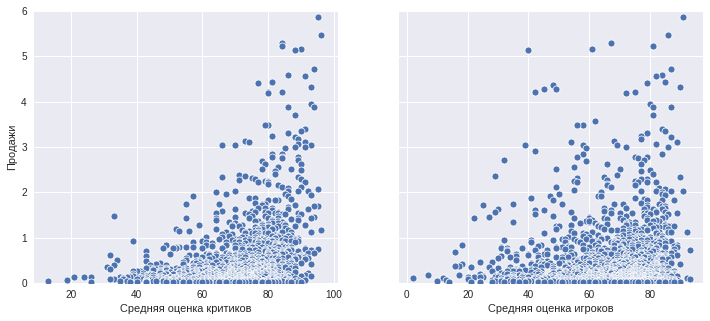

In [84]:
other_games = relevant_games.query('platform not in ["XOne", "PS4"]')

f, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax1 = sns.scatterplot(data = other_games, x = 'critic_score', y = 'total_sales', ax = axes[0])
ax1.set(xlabel = 'Средняя оценка критиков', ylabel = 'Продажи', ylim = (0, 6))

ax2 = sns.scatterplot(data = other_games, x = 'user_score', y = 'total_sales', ax = axes[1])
ax2.set(xlabel = 'Средняя оценка игроков', ylabel = 'Продажи',  ylim = (0, 6))
plt.show

print('Коэффициент корреляции оценок критиков и продаж игры:\t\t', 
      other_games['critic_score'].corr(other_games['total_sales']))
print('Коэффициент корреляции пользовательских оценок и продаж игры:\t', 
      other_games['user_score'].corr(other_games['total_sales']))

Для остальных платформ картина не меняется.

Данный результат вполне ожидаем - логично, что большинство покупателей принимает решение о покупке игры на основании обзоров, причем чем выше оценка, тем больше вероятность, что большее количество людей купят игру. При этом критики как правило публикуют свои обзоры либо перед или во время выхода игры, в то время как пользовательский рейтинг составляется намного позже, когда основные продажи уже прошли, и оказывает меньшее влияние на них.

#### Зависимость продаж от жанра

Изучим как продажи игры соотносятся с ее жанром. Построим график суммарных продаж игр каждого жанра:

In [85]:
sales_by_genre = (relevant_games.pivot_table(index = 'genre', 
                                             values = 'total_sales', 
                                             aggfunc = ['sum', 'median', 'count'])
                  .reset_index())
sales_by_genre.columns = sales_by_genre.columns.droplevel(1)

fig1 = px.bar(sales_by_genre.sort_values('sum', ascending = False), x = 'genre', y = 'sum', height = 400,
             title = 'Суммарные продажи игр по жанрам', labels = {'genre': 'Жанр', 'sum': 'Продажи'})
fig1.show()

Наибольшую долю рынка видеоигр за последние 6 лет составили экшн-игры, шутеры, RPG и спортивные игры. Посмотрим теперь, каковы средние продажи игр в каждом жанре:

In [86]:
fig1 = px.bar(sales_by_genre.sort_values('median', ascending = False), x = 'genre', y = 'median', height = 400,
             title = 'Средние продажи игр по жанрам', labels = {'genre': 'Жанр', 'median': 'Продажи'})
fig1.show()

Наиболее прибыльными жанрами оказались шутеры, спортивные игры платформеры и файтинги. Примечательно, что последние два жанра опередили экшн-игры по средним продажам, в то время как на предыдущем графике было видно, что они составляют очень малую часть рынка. Это может означать, что есть спрос на игры данных жанров, в то время как рынок игр в жанре *Action*, наоборот, пересыщен.

### Выводы

На этом шаге мы провели анализ наших данных, чтобы найти потенциально прибыльные платформы и игры. Сначала нами был определен актуальный период, который стоит исследовать. Он равен 5-6 годам - за такое время происходит смена поколений игровых консолей, которые и определяют тенденции на рынке видеоигр. 

Также мы исключили из анализа консоли, для которых в 2016 году не выходило новых игр - очевидно, что для прогноза на следующий год они также уже не актуальны.

Далее мы проанализировали тренды продаж игр на отобранных нами платформах. Было выяснено, что наиболее перспективными на текущий момент являются консоли Playstation 4 и XBox One, которые появились в 2013 году и с тех пор испытывают стабильных рост. WiiU, также относящаяся к последнему поколению, в силу своей нишевости и меньшей популярности показывает худший результат. Консоли же прошлого поколения (Xbox 360, PS3, Wii и прочие) находятся на спаде и не могут рассматриваться как перспективные.

Также нами изучены факторы, которые могут влиять на продажи игр, и получены следующие результаты:
1. Если исключить более нишевые консоли типа 3DS и PS Vita, а также персональные компьютеры, то среднее количество проданных копий игры не сильно различаются от платформы к платформе. В то же время в силу большей популярности консолей Playstation и XBox на них выходят все наиболее успешные игры, что влечет за собой выдающиеся продажи. Если говорить о прогнозах на следующий год, то именно на PS4 и XBox One стоит ждать появления новых хитов.
2. Обнаружена определенная зависимость продаж игр от отзывов критиков; величина коэффициента корреляции составила около 0.3. Это соответсвует ожиданиям, поскольку именно обзоры на профильных ресурсах и определяют, как много игроков узнают об игре и решат ее купить. В тоже время это не является определяющим фактором, поскольку на продажи также сильно влияет степень ожидаемости игры, которая не сильно связана с ее итоговым качеством. Значимой корреляции между пользовательскими оценками и продажами игры не обнаружено. 
4. В зависимости от жанра было обнаружено, что наиболее прибыльными в среднем оказались шутеры, спортивные игры и платформеры, наименее популярными - стратегии, головоломки и игры в жанре _Adventure_. Наибольшую долю от рынка при этом составляют жанры _Action_ и _Shooter_.

## Шаг 4. Различия между игроками разных регионов

Проанализируем, как различаются предпочтения пользователей из различных частей света. Для этого для каждого региона (Северная Америка, Европа, Япония) найдем топ-5 самых популярных платформ, жанров, а также проследим, как влияет на продажи возрастной рейтинг игры.

### Платформы

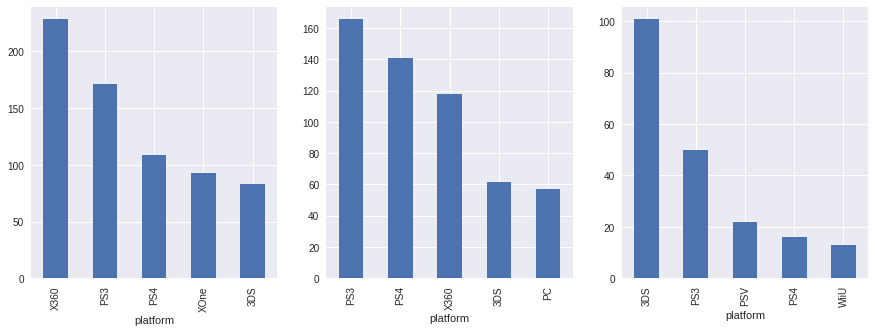

In [87]:
def region_compare(category) :   
    f, axes = plt.subplots(1, 3, figsize = (15, 5))
    axis = iter([0,1,2])
    ax1, ax2, ax3 = (relevant_games.groupby(category)[region].sum()
                 .sort_values(ascending = False)[0:5]
                 .plot.bar(ax = axes[next(axis)]) for region in ['na_sales', 'eu_sales', 'jp_sales'])
    plt.show()
    
region_compare('platform')

Как мы видим, в Америке наиболее популярна приставка XBox 360, за которой следуют PS3 и PS4. В Европе, наоборот, более распространены PS3 и PS4, а в Японии с сильным отрывом лидирует 3DS.

Теперь рассмотрим различия в жанровых предпочтениях:

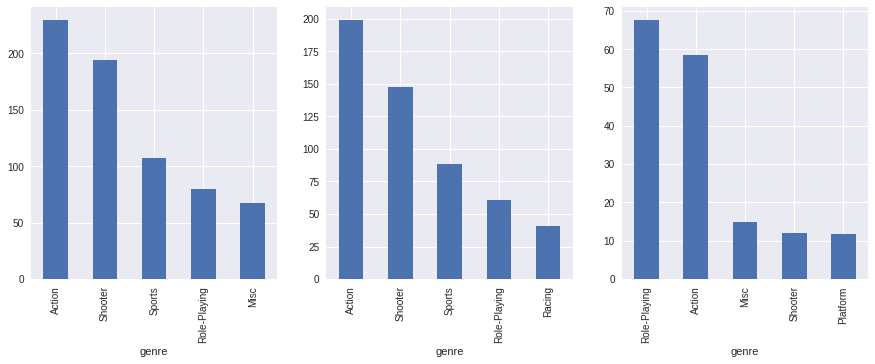

In [88]:
region_compare('genre')

В жанрах предпочтения у американских и европейских игроков очень похожи - лидируют экшн-игры, шутеры и спортивные симуляторы. У японцев же на первое место выходят ролевые игры, а спорт не попадает даже в Топ-5.

Наконец, рассмотрим, как хорошо продаются игры в зависимости от возрастного рейтинга:

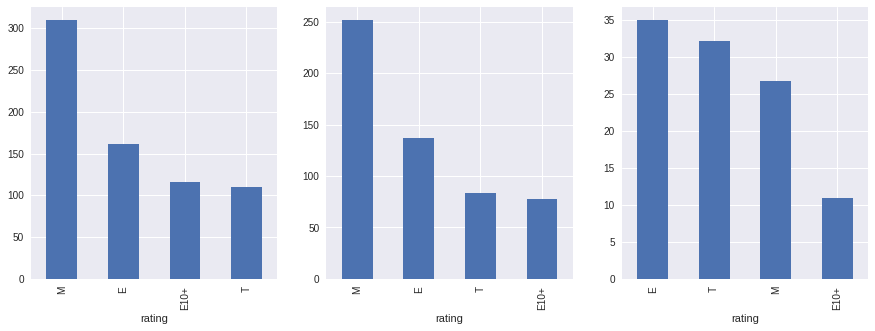

In [89]:
region_compare('rating')

Как и в предыдущем случае, между Северной Америкой и Европой особой разницы нет. Наиболее популярны там игры с рейтингами M. В Японии же игры для взрослой аудитории продаются хуже, чем E и T, что позволяет сделать вывод о том, что в данном регионе рейтинг влияет на величину продаж.

### Вывод

На этом шаге мы составили портреты пользователей разных регионов: NA, EU  и JP. Выяснили следующее:
1. Игроки из Америки и Европы имеют схожие предпочтения в жанрах: там лидируют игры Action, Shooter, Sports. В Японии же первое место занимают традиционные для этой страны ролевые игры, а шутеры и спортивные игры намного менее популярны;
2. В плане предпочитаемых консолей в Америке и Европе наиболее популярны XBox 360, PS3 и набирающая обороты PS4. При этом в Америке более распространен XBox, а в Европе Playstation. В Японии наиболее успешной оказалась Nintendo 3DS, которая обгоняет конкурентов практически в два раза;
3. Возрастной рейтинг оказывает влияние на продажи игр в Японии.

## Шаг 5. Проверка гипотез

### 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем нулевую гипотезу:

    Средние значения пользовательского рейтинга для игр на XBox One и на PC равны.
Для проверки данной гипотезы для начала оценим распределения пользовательских оценок игр на данных платформах:

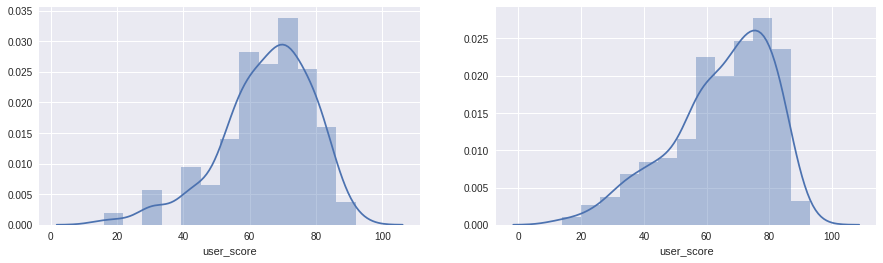

Дисперсия значений для XOne равна 189.65189 , для PC  - 256.77777
Среднее значение для XOne равно 65.21429 , для PC - 64.66242


In [90]:
f, axes = plt.subplots(1, 2, figsize = (15, 4))
ax1 = sns.distplot(relevant_games.query('platform == "XOne"')['user_score'].dropna(), ax = axes[0])
ax2 = sns.distplot(relevant_games.query('platform == "PC"')['user_score'].dropna(), ax = axes[1])
plt.show()
print('Дисперсия значений для XOne равна', np.var(relevant_games.query('platform == "XOne"')['user_score']),
      ', для PC  -', np.var(relevant_games.query('platform == "PC"')['user_score']))
print('Среднее значение для XOne равно', relevant_games.query('platform == "XOne"')['user_score'].mean(), 
      ', для PC -', relevant_games.query('platform == "PC"')['user_score'].mean())

Оба распределения близки к нормальным, но дисперсии различаются. Для проверки нулевой гипотезы воспользуемся функцией *ttest_ind* из модуля *scipy.stats* указав параметр *equal_var* (равенство дисперсий) как *False*. Пороговый уровень значимости зададим равным 0.05.

In [91]:
ttest_xone_pc = st.ttest_ind(relevant_games.query('platform == "PC"')['user_score'].dropna(),
                             relevant_games.query('platform == "XOne"')['user_score'].dropna(),
                             equal_var = False)
print('p-значение:', ttest_xone_pc.pvalue)
if ttest_xone_pc.pvalue < .05:
    print('Нулевая гипотеза неверна.')
else:
    print('Нулевая гипотеза верна')

p-значение: 0.6865921864331199
Нулевая гипотеза верна


Полученное p-значение не позволяет отвергнуть нулевую гипотезу, из чего делаем вывод, что средние ользовательские рейтинги на платформах Xbox One и PC равны.

### 2. Средние пользовательские рейтинги жанров Action и Sports разные

В этом случае нулевая гипотеза будет формулироваться так:
                            
    Средние значения пользовательского рейтинга для игр жанров Action и Sports равны.
    
Как и в предыдущем пункте, сперва проверим распределения значений сравниваемых выборок:

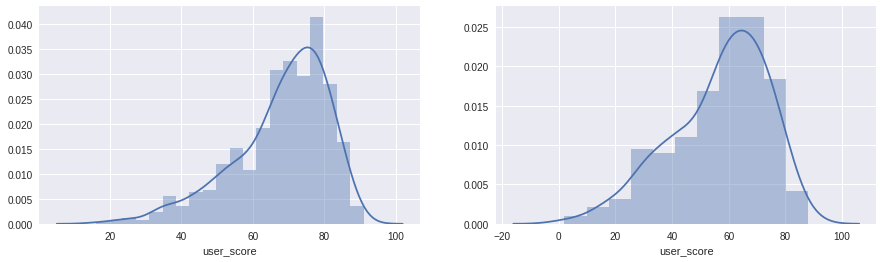

Дисперсия значений для Action равна 177.93703 , для Sports  - 288.92
Среднее значение для Action равно 67.91194 , для Sports - 56.64609


In [92]:
f, axes = plt.subplots(1, 2, figsize = (15, 4))
ax1 = sns.distplot(relevant_games.query('genre == "Action"')['user_score'].dropna(), ax = axes[0])
ax2 = sns.distplot(relevant_games.query('genre == "Sports"')['user_score'].dropna(), ax = axes[1])
plt.show()
print('Дисперсия значений для Action равна', np.var(relevant_games.query('genre == "Action"')['user_score']),
      ', для Sports  -', np.var(relevant_games.query('genre == "Sports"')['user_score']))
print('Среднее значение для Action равно', relevant_games.query('genre == "Action"')['user_score'].mean(), 
      ', для Sports -', relevant_games.query('genre == "Sports"')['user_score'].mean())

Распределения близки к нормальным. Найдем p-значение:

In [93]:
ttest_action_sports = st.ttest_ind(relevant_games.query('genre == "Action"')['user_score'].dropna(),
                                   relevant_games.query('genre == "Sports"')['user_score'].dropna(),
                                   equal_var = True)
print('p-значение:', ttest_action_sports.pvalue)
if ttest_action_sports.pvalue < .05:
    print('Нулевая гипотеза неверна.')
else:
    print('Нулевая гипотеза верна')

p-значение: 3.774389002596942e-24
Нулевая гипотеза неверна.


В данном случае полученное p-значение позволяет нам отклонить нулевую гипотезу.

### Вывод

Нами произведена проверка гипотез:
1. "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые". При проверке данной гипотезы получено p-значение 0.68, что означает, что мы не отвергаем нулевую гипотезу. Следовательно, отзывы игроков не зависят от того, на какой из этих двух платформ они играли в игру.
2. "Средние пользовательские рейтинги жанров Action и Sports разные". В этом случае p-значение получилось намного меньше порогового значения, что позволило нам отклонить нулевую гипотезу и, таким образом, подтвердить наше предположение: игры этих двух жанров получают различные отзывы игроков.


## Общие выводы

В данной работе мы произвели исследование рынка видеоигр по состоянию на конец 2016 года. Нами были получены сведения о продажах игр, выходивших за предыдущие годы на разных платформах, оценки критиков и пользователей и прочая информация.

Мы изучили полученные данные преобразовали их к нужному типу и заполнили пропуски, где необходимо. Также для каждой игры мы рассчитали суммарные продажи во всех регионах и добавили соответствующий столбец в таблицу.

Далее мы выделили актуальный временной период и платформы, которые помогут нам охарактеризовать состояние рынка на текущий момент. В качестве временного периода мы взяли последние 6 лет - средний срок сменяемости игровых консолей; в качестве игровых платформ, которые будут актуальны в 2017 году, нами выбраны те, для которых еще выходили новые игры в прошлом году:

In [94]:
for i in relevant_platforms:
    print(i)

3DS
PC
PS3
PS4
PSV
Wii
WiiU
X360
XOne


Из этих платформ потенциально прибыльными являются новые консоли Playstation 4 и XBox One, которые в последние годы испытывали рост, и, как ожидается, продолжат развиваться в следующем году. Из них по суммарному количеству продаж лидирует PS4, однако среднее число проданных копий каждой игры практически не различается.

Помимо этого, мы проанализировали, насколько влияют на продажи игр такие факторы, как оценка критиков, отзывы игроков и жанр. Получили следующие результаты:
- Оценка критиков положительно коррелирует с продажами игры; коэффициент корреляции равен примерно 0.3 - отзывы критиков могут оказывать влияние на успешность игры, но не являются определяющим фактором;
- Значимой связи между оценкой игроков и продажами игры не обнаружено;
- Что касается жанров, то наиболее популярным за исследуемый период оказался Shooter, за которым следуют Sports, Platform и остальные. Наименее интересными для игроков являются жанры Puzzle, Adventure и Strategy.

Также нами составлены портреты пользователей основных регионов (Северной Америки, Европы и Японии) в плане предпочитаемых платформ и жанров:
- В Америке и Европе по продажам лидируют игры жанров Action, Shooter, Sports. В Японии наиболее популярны RPG и экшн-игры;
- В первых двух регионах наиболее распространены консоли XBox 360, PS3 и PS4 (в Америке на первом месте XBox, в Европе - PS 3). В Японии лидирует Nintendo 3DS;

Так же замечено, что в Японии намного меньше продажи игр с рейтингом _M_.

Наконец, нами проверены два предположения:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action и Sports разные.

Оба этих предположения были подтверждены на основе результатов t-тестирования.